<a href="https://colab.research.google.com/github/Jules-gatete/RxMediq_Summative-assignment---MLOP/blob/main/RxMediq_Model_Jules_Gatete_assignment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#IMPORTING LIBRARIES

In [9]:
# Import Necessary Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model, save_model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, Adagrad
from tensorflow.keras.regularizers import l1
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.compose import ColumnTransformer
import joblib
from google.colab import files
import os
import joblib
from sklearn.preprocessing import StandardScaler, LabelEncoder  # Import necessary classes
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Set random seed for reproducibility

In [2]:
# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("✓ Libraries imported successfully!")

✓ Libraries imported successfully!


# Load dataset



In [4]:
# Load dataset
file_path = "/content/drive/MyDrive/Drug prescription Dataset.csv"

df = pd.read_csv(file_path)

print("\n✓ Dataset loaded successfully from:", file_path)


✓ Dataset loaded successfully from: /content/drive/MyDrive/Drug prescription Dataset.csv


#DATA EXPLORATION

In [5]:
def explore_data(df):
    """Display basic information and statistics about the dataset."""
    print("\n=== Dataset Preview ===")
    print(df.head())
    print("\n=== Dataset Info ===")
    print(df.info())
    print("\n=== Dataset Statistics ===")
    print(df.describe())
    print("\n=== Missing Values ===")
    print(df.isnull().sum())

explore_data(df)


=== Dataset Preview ===
    disease  age gender severity                drug
0  diarrhea    4   male      LOW  promegranate drink
1  diarrhea    4   male   NORMAL          lime juice
2  diarrhea    5   male      LOW  promegranate drink
3  diarrhea    5   male   NORMAL          lime juice
4  diarrhea    6   male      LOW  promegranate drink

=== Dataset Info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1288 entries, 0 to 1287
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   disease   1288 non-null   object
 1   age       1288 non-null   int64 
 2   gender    1288 non-null   object
 3   severity  1288 non-null   object
 4   drug      1288 non-null   object
dtypes: int64(1), object(4)
memory usage: 50.4+ KB
None

=== Dataset Statistics ===
               age
count  1288.000000
mean     33.645963
std      15.532570
min       4.000000
25%      20.000000
50%      34.000000
75%      47.000000
max      60.000000

=== Mis

#DATA VISUALIZATION

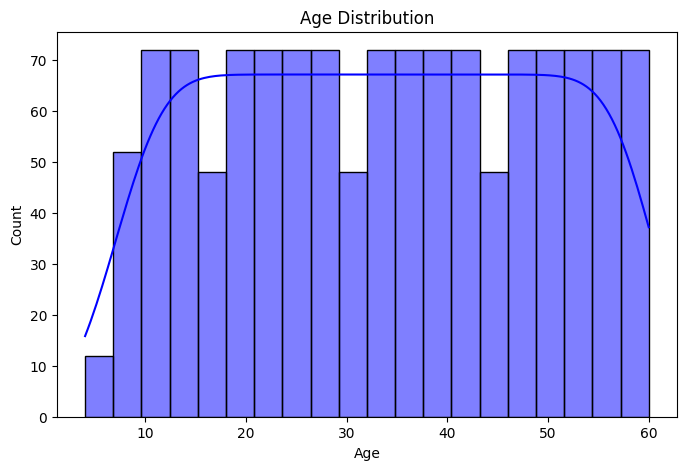

Story: Age distribution highlights patient age range, suggesting age-specific drug trends.


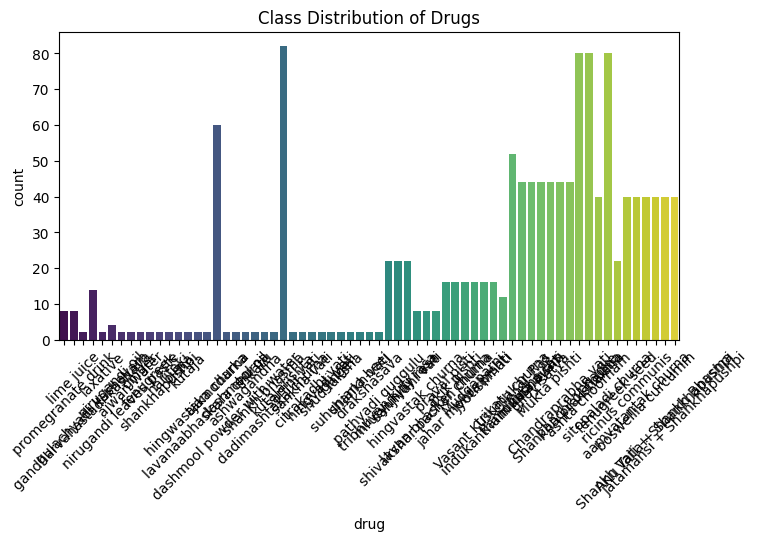

Story: Drug distribution shows prescription frequency, indicating common treatments.


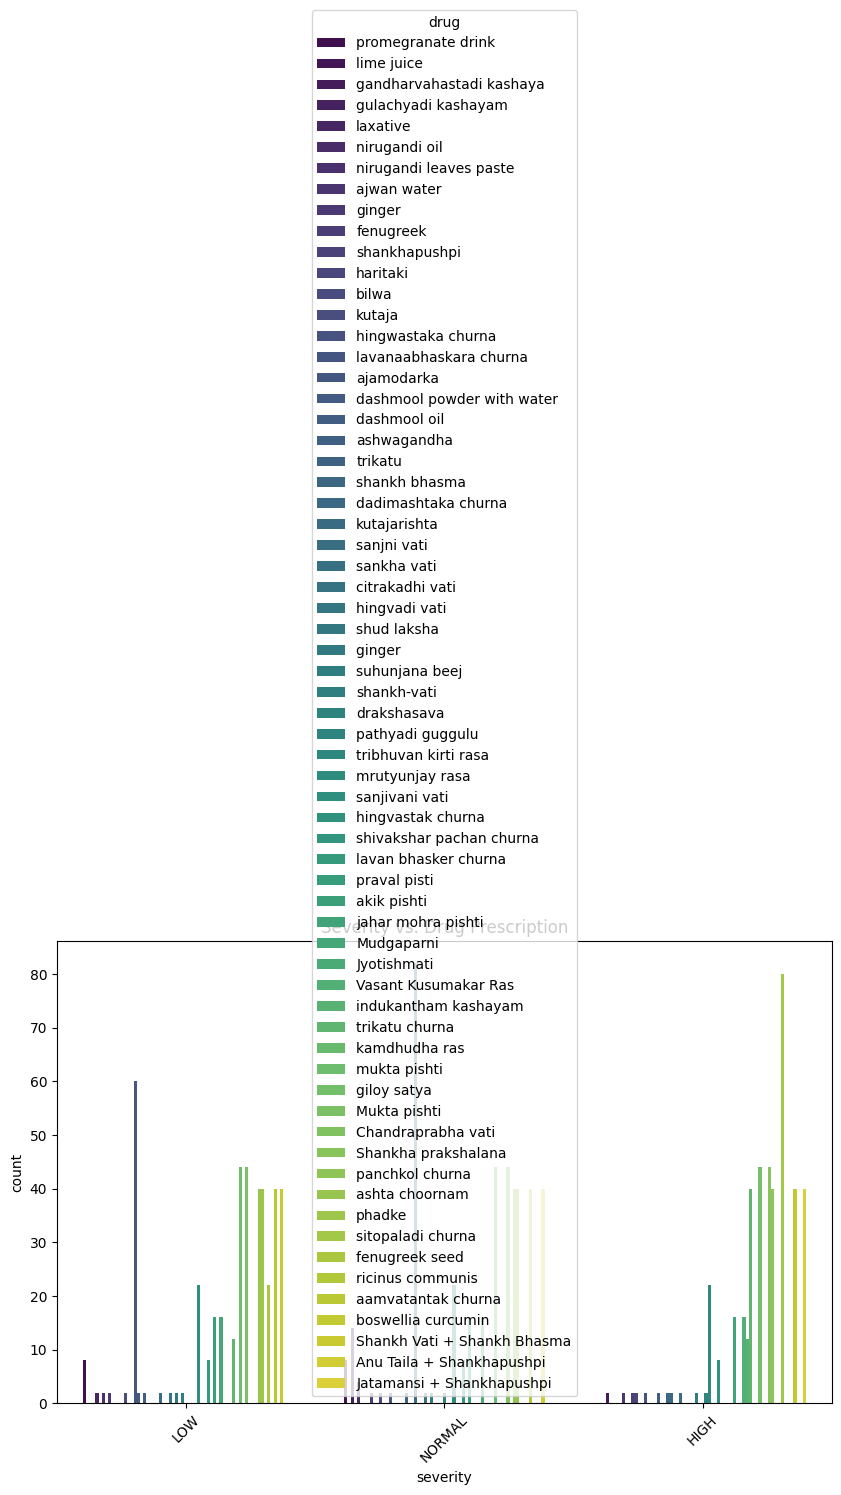

Story: Severity influences drug choice, with distinct preferences per level.


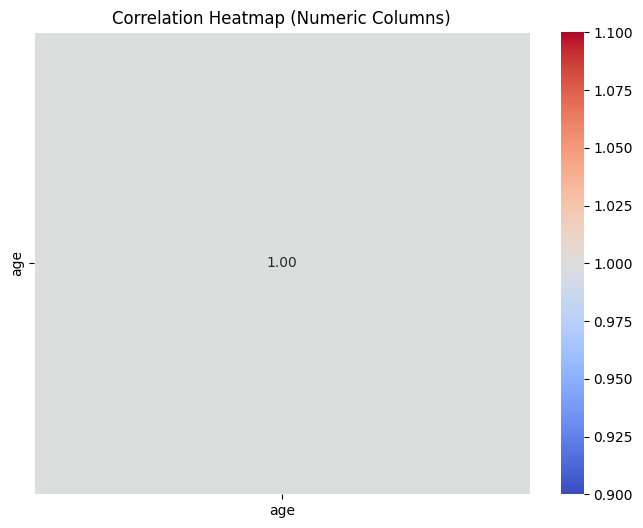

Story: Correlation heatmap shows relationships between numeric features.


In [6]:
def visualize_data(df):
    """Generate visualizations to understand data distributions."""
    # Age Distribution
    plt.figure(figsize=(8, 5))
    sns.histplot(df["age"], bins=20, kde=True, color="blue")
    plt.title("Age Distribution")
    plt.xlabel("Age")
    plt.ylabel("Count")
    plt.show()
    print("Story: Age distribution highlights patient age range, suggesting age-specific drug trends.")

    # Drug Distribution
    plt.figure(figsize=(8, 4))
    sns.countplot(x="drug", hue="drug", data=df, palette="viridis", legend=False)
    plt.title("Class Distribution of Drugs")
    plt.xticks(rotation=45)
    plt.show()
    print("Story: Drug distribution shows prescription frequency, indicating common treatments.")

    # Severity vs. Drug
    plt.figure(figsize=(10, 6))
    sns.countplot(x="severity", hue="drug", data=df, palette="viridis")
    plt.title("Severity vs. Drug Prescription")
    plt.xticks(rotation=45)
    plt.show()
    print("Story: Severity influences drug choice, with distinct preferences per level.")

    # Correlation Heatmap (numeric columns only)
    numeric_df = df.select_dtypes(include=np.number)
    corr_matrix = numeric_df.corr()
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
    plt.title("Correlation Heatmap (Numeric Columns)")
    plt.show()
    print("Story: Correlation heatmap shows relationships between numeric features.")

visualize_data(df)

#DATA PREPROCESSING FUNCTIONS



In [10]:
def preprocess_data(df):
    """Preprocesses the dataset."""
    # 1. Label Encoding for Categorical Features
    label_encoders = {}
    categorical_cols = ["disease", "gender", "severity", "drug"]
    for col in categorical_cols:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
        label_encoders[col] = le

    # 2. Feature Scaling for Numerical Features
    numerical_cols = ["age"]
    num_pipeline = Pipeline([
        ('scaler', StandardScaler())
    ])

    # 3. Combine Preprocessing Steps
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', num_pipeline, numerical_cols),
            ('cat', 'passthrough', categorical_cols[:-1])  # Exclude 'drug' (target)
        ])

    # 4. Apply Preprocessing
    X = preprocessor.fit_transform(df.drop(columns=["drug"]))
    y = df["drug"].values

    return X, y, label_encoders, preprocessor

# Preprocess Data
X, y, label_encoders, preprocessor = preprocess_data(df)

# Split data
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.40, random_state=42, stratify=y)

# Check for rare classes in y_temp and handle them before splitting into validation and test sets
unique_classes, counts = np.unique(y_temp, return_counts=True)
rare_classes = unique_classes[counts < 2]  # Identify rare classes with less than 2 samples

if len(rare_classes) > 0:
    print(f"\n⚠️ Rare classes detected in y_temp (count < 2): {rare_classes}")
    # Option 1: Remove rare classes from X_temp and y_temp
    # mask = ~np.isin(y_temp, rare_classes)
    # X_temp = X_temp[mask]
    # y_temp = y_temp[mask]
    # print(f"✓ Removed {len(rare_classes)} rare classes. New y_temp size: {len(y_temp)}")

    # Option 2: If removing rare classes is not desirable, consider not stratifying for the validation/test split
    print("⚠️ Proceeding without stratification for validation/test split due to rare classes.")
    stratify_val_test = None  # Disable stratification for this split
else:
    stratify_val_test = y_temp  # Use stratification if all classes have at least 2 samples

# Split into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42, stratify=stratify_val_test)


⚠️ Rare classes detected in y_temp (count < 2): [11 14 15 17 18 19 20 21 22 24 26 27 29 30 32 36 39 40 44 45 47 53 54 55
 56 57 59 61 63]
⚠️ Proceeding without stratification for validation/test split due to rare classes.


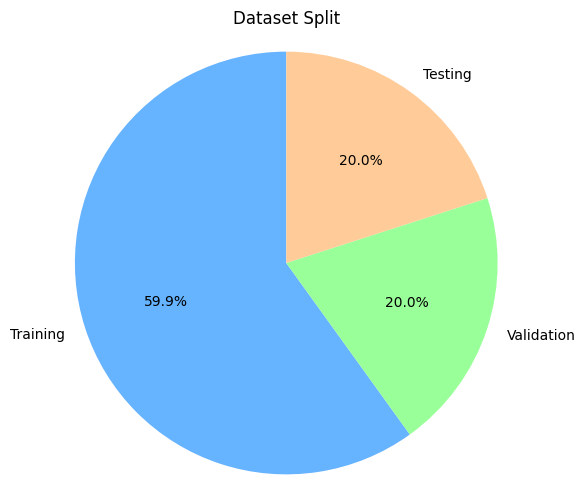

Training set size: 772
Validation set size: 258
Testing set size: 258


In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have X_train, X_val, X_test after the split
train_size = X_train.shape[0]
val_size = X_val.shape[0]
test_size = X_test.shape[0]

# Create labels and sizes for the pie chart
labels = ['Training', 'Validation', 'Testing']
sizes = [train_size, val_size, test_size]
colors = ['#66b3ff', '#99ff99', '#ffcc99']  # Light blue, light green, light orange

# Create the pie chart
plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.title('Dataset Split')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

print(f"Training set size: {train_size}")
print(f"Validation set size: {val_size}")
print(f"Testing set size: {test_size}")

#MODEL TRAINING

In [12]:
def build_and_train_model(X_train, y_train, X_val, y_val, num_classes):
    """Build and train a neural network with optimization techniques."""
    # The imports for BatchNormalization and Adagrad should be outside the function definition
    # from tensorflow.keras.layers import BatchNormalization
    # from tensorflow.keras.optimizers import Adagrad

    # Model 6: AdaGrad + Batch Normalization
    adagrad_bn_model = Sequential([
        Dense(64, activation='relu'),
        BatchNormalization(),  # Now BatchNormalization should be recognized
        Dropout(0.2),
        Dense(48, activation='relu'),
        BatchNormalization(),
        Dense(32, activation='relu'),
        BatchNormalization(),
        Dense(len(np.unique(y)), activation='softmax')
    ])

    # Now compile the model with the imported Adagrad optimizer
    adagrad_bn_model.compile(optimizer=Adagrad(learning_rate=0.01), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    history_adagrad = adagrad_bn_model.fit(X_train, y_train, epochs=200, batch_size=32, validation_split=0.2, verbose=0,
                                           callbacks=[EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)])
    # evaluate_model call should be outside the function, since it needs the model and history to evaluate the model
    # adagrad_bn_metrics = evaluate_model(adagrad_bn_model, X_test, y_test, "AdaGrad + Batch Normalization", history_adagrad)

    return adagrad_bn_model, history_adagrad # Return the correct model and history

In [13]:
# Train the model
num_classes = len(np.unique(y))
model, history = build_and_train_model(X_train, y_train, X_val, y_test, num_classes)
print("\n✓ Model training completed!")


✓ Model training completed!


#MODEL EVALUATION

In [14]:
def evaluate_model(model, X_test, y_test, model_name, history=None):
    """Evaluate the model using multiple metrics and visualizations."""
    # Compute loss and predictions
    loss = model.evaluate(X_test, y_test, verbose=0)[0]
    y_pred_probs = model.predict(X_test)
    y_pred = np.argmax(y_pred_probs, axis=1)

    # Calculate metrics
    metrics = {
        "Loss": loss,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, average='weighted', zero_division=1),
        "Recall": recall_score(y_test, y_pred, average='weighted', zero_division=1),
        "F1 Score": f1_score(y_test, y_pred, average='weighted'),
        "Confusion Matrix": confusion_matrix(y_test, y_pred)
    }

    # Display metrics
    print(f"\n=== Performance Metrics - {model_name} ===")
    print(f"Loss: {metrics['Loss']:.4f}")
    print(f"Accuracy: {metrics['Accuracy']:.4f}")
    print(f"Precision: {metrics['Precision']:.4f}")
    print(f"Recall: {metrics['Recall']:.4f}")
    print(f"F1 Score: {metrics['F1 Score']:.4f}")

    # Plot training history
    if history:
        plt.figure(figsize=(8, 5))
        plt.plot(history.history['accuracy'], label='Train Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.title(f"Training History - {model_name}")
        plt.xlabel("Epochs")
        plt.ylabel("Accuracy")
        plt.legend()
        plt.show()

    # Create heatmap for confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(metrics["Confusion Matrix"], annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    return metrics

# Evaluate the model


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step

=== Performance Metrics - AdaGrad + Batch Normalization ===
Loss: 0.4848
Accuracy: 0.8721
Precision: 0.8977
Recall: 0.8721
F1 Score: 0.8436


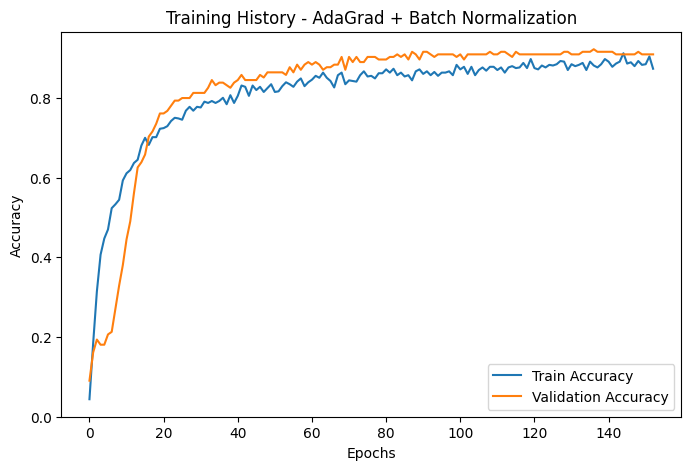

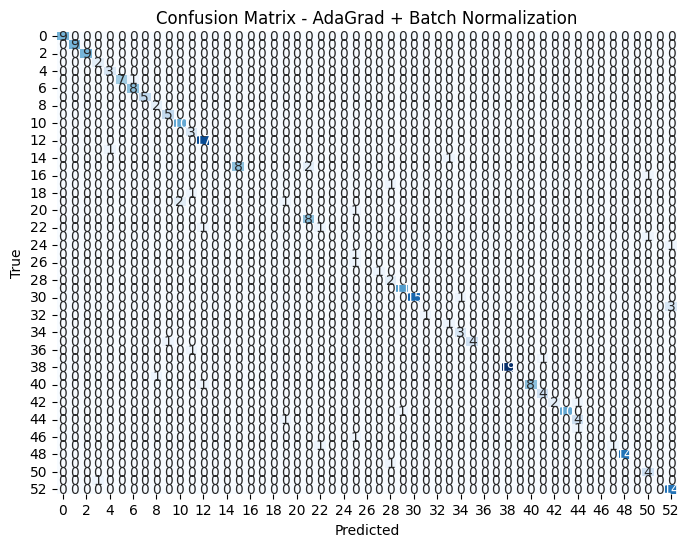

In [15]:
# Evaluate the model
metrics = evaluate_model(model, X_test, y_test, "AdaGrad + Batch Normalization", history)

#SAVING MODEL AND PREPROCESSORS

In [20]:
# Create necessary directories
import os
import joblib
import numpy as np
from google.colab import files

os.makedirs("/content/models", exist_ok=True)
os.makedirs("/content/train", exist_ok=True)

# Save the model inside /content/models/
model_path = "/content/models/drug_prediction_model.keras"
model.save(model_path)
print(f"\n✓ Model saved in .keras format at: {model_path}")

# Extract and save the StandardScaler inside /content/models/
scaler = preprocessor.named_transformers_['num']
scaler_path = "/content/models/standard_scaler.pkl"
joblib.dump(scaler, scaler_path)
print(f"✓ StandardScaler saved at: {scaler_path}")

# Save label encoders and preprocessor inside /content/models/
encoders_path = "/content/models/label_encoders.pkl"
preprocessor_path = "/content/models/preprocessor.pkl"
joblib.dump(label_encoders, encoders_path)
joblib.dump(preprocessor, preprocessor_path)
print(f"✓ Label encoders saved at: {encoders_path}")
print(f"✓ Preprocessor saved at: {preprocessor_path}")

# Save training data inside /content/train/
X_train_path = "/content/train/X_train.npy"
y_train_path = "/content/train/y_train.npy"
np.save(X_train_path, X_train)
np.save(y_train_path, y_train)
print(f"✓ Training data saved for retraining at: {X_train_path}, {y_train_path}")

# Zip only the models folder (excluding the train folder)
!zip -r "/content/models.zip" "/content/models/"

# Download the zipped models folder locally
files.download("/content/models.zip")
print("✓ Models and preprocessors zipped and downloaded!")



✓ Model saved in .keras format at: /content/models/drug_prediction_model.keras
✓ StandardScaler saved at: /content/models/standard_scaler.pkl
✓ Label encoders saved at: /content/models/label_encoders.pkl
✓ Preprocessor saved at: /content/models/preprocessor.pkl
✓ Training data saved for retraining at: /content/train/X_train.npy, /content/train/y_train.npy
updating: content/models/ (stored 0%)
updating: content/models/preprocessor.pkl (deflated 52%)
updating: content/models/standard_scaler.pkl (deflated 38%)
updating: content/models/label_encoders.pkl (deflated 58%)
updating: content/models/drug_prediction_model.keras (deflated 43%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✓ Models and preprocessors zipped and downloaded!


#PREDICTION FUNCTION

In [ ]:
def predict_single(model, preprocessor, label_encoders, data_point):
    """Predict the drug for a single data point."""
    df = pd.DataFrame([data_point], columns=["disease", "age", "gender", "severity"])
    for col in ["disease", "gender", "severity"]:
        df[col] = label_encoders[col].transform([df[col][0]])
    X = preprocessor.transform(df)
    pred_probs = model.predict(X)
    pred_class = np.argmax(pred_probs, axis=1)[0]
    pred_drug = label_encoders["drug"].inverse_transform([pred_class])[0]
    return pred_drug

# Example prediction
sample_data = {"disease": "diarrhea", "age": 30, "gender": "male", "severity": "NORMAL"}
prediction = predict_single(model, preprocessor, label_encoders, sample_data)
print(f"\n✓ Sample Prediction: {prediction}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step

✓ Sample Prediction: kutajarishta
